# Model Evaluation

## Objective 
Understand the significance of partition of community based on rating difference. Include statistical model evaluation. 

## Process 
1. Data EDA - Using the "network_with_fake.json" data, understand the EDA and visualization of community detection. Understand rating distribution. 
2. Perform community detection based on rating difference between players of each game.
3. Perform model evaluation. Confusion matrix, precision metrics, hypothesis testing (ANOVA), etc.
4. Visualize the model assessment. 

In [1]:
import json
import networkx as nx
from community import best_partition
from community import community_louvain
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
from scipy import stats
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from collections import defaultdict, Counter
from scipy.stats import spearmanr
import statsmodels.api as sm
from scipy.stats import ttest_ind


# Data Exploration
Data **network_with_fake.json** includes information of network graph of all the current nodes/edges collected thus far including 5 fake players. These can be identified as username: "findwaldo[1-5]". They each have different ratings across the spectrum, and they have randomly played with 5-50 players in the network (1-15 games per interaction). And they've won every game

In [2]:
file_path = "network.json"  

with open("network_with_fake.json", "r") as f:
    data = json.load(f)
g = nx.node_link_graph(data)

In [3]:
# Get the total number of nodes in the graph
total_nodes = g.number_of_nodes()

print(f"Total number of nodes in the graph: {total_nodes}")

Total number of nodes in the graph: 19927


These nodes represent chess players, with unique attributes describing their profile, including a username, country, and rating. Weight: 80 (potentially representing the number of interactions or intensity of the connection between these two players).

In [4]:
# Inspect nodes
print("\nNodes (First 2):")
for i, (node, attributes) in enumerate(g.nodes(data=True)):
    print(f"Node {i+1}: {node}, Attributes: {attributes}")
    if i == 1:  # Let's look at the first two nodes
        break

# Inspect edges
print("\nEdges (First Edge):")
for i, (source, target, attributes) in enumerate(g.edges(data=True)):
    print(f"Edge {i+1}: Source: {source}, Target: {target}, Attributes: {attributes}")
    if i == 0:  # Let's look at their edge
        break



Nodes (First 2):
Node 1: ecztery, Attributes: {'uid': 6463628, 'name': 'Damian Śliwicki', 'username': 'ecztery', 'country': 'PL', 'rating': 2198}
Node 2: zera_kv, Attributes: {'uid': 76486022, 'name': 'Štěpán Tichý', 'username': 'zera_kv', 'country': 'CZ', 'rating': 2278}

Edges (First Edge):
Edge 1: Source: ecztery, Target: zera_kv, Attributes: {'weight': 80, 'data': [{'pgn': '[Event "Live Chess"]\n[Site "Chess.com"]\n[Date "2024.10.01"]\n[Round "-"]\n[White "eCztery"]\n[Black "Zera_KV"]\n[Result "1-0"]\n[CurrentPosition "7r/3R1p1P/4pk2/5r2/8/1P3P2/P5P1/1K5R b - -"]\n[Timezone "UTC"]\n[ECO "C11"]\n[ECOUrl "https://www.chess.com/openings/French-Defense-Classical-Steinitz-Variation-4...Nfd7-5.Nf3-c5"]\n[UTCDate "2024.10.01"]\n[UTCTime "17:09:01"]\n[WhiteElo "2470"]\n[BlackElo "2443"]\n[TimeControl "60"]\n[Termination "eCztery won on time"]\n[StartTime "17:09:01"]\n[EndDate "2024.10.01"]\n[EndTime "17:11:11"]\n[Link "https://www.chess.com/game/live/121541453405"]\n\n1. d4 {[%clk 0:00:59

## Rating Distribution Bar Chart
The histogram below demonstrates a slightly left-skewed distribution, with the majority of players falling within the 1900-2300 range.
Potential anomalies could be players with extremely low or high ratings.

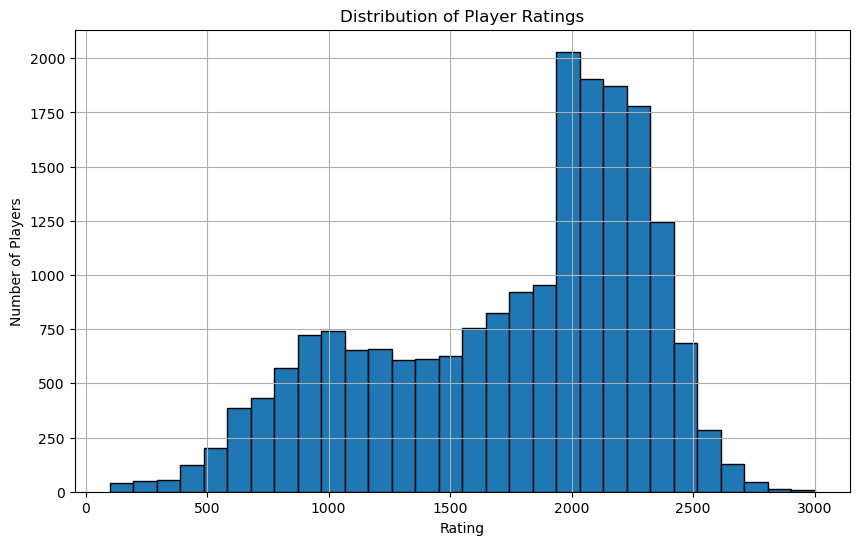

In [5]:
# Rating distribution
df_nodes = pd.DataFrame.from_dict(dict(g.nodes(data=True)), orient='index')

plt.figure(figsize=(10, 6))
plt.hist(df_nodes['rating'], bins=30, edgecolor='k')
plt.title("Distribution of Player Ratings")
plt.xlabel("Rating")
plt.ylabel("Number of Players")
plt.grid(True)
plt.show()

## Win/Loss Ratio Distribution by Player

The following shows win/loss ratio by player, which is also sorted by the ratio. For the top 10 players, they had the following matches and had no losses so far. Given the few games that the top 10 ratio players played, it is difficult to extract anomalies as they might have been skillful in chess. 

In [7]:

# Calculate win/loss ratio for each player
win_loss = defaultdict(lambda: {'wins': 0, 'losses': 0})

# Iterate through edges and calculate wins/losses
for _, _, attr in g.edges(data=True):
    for game in attr['data']:
        if game['white']['result'] == 'win':
            win_loss[game['white']['username']]['wins'] += 1
            win_loss[game['black']['username']]['losses'] += 1
        elif game['black']['result'] == 'win':
            win_loss[game['black']['username']]['wins'] += 1
            win_loss[game['white']['username']]['losses'] += 1

# Make a new df that contains the information
win_loss_df = pd.DataFrame.from_dict(win_loss, orient='index')

# Calculate win/loss ratio, handle the zero loss (zero division) cases
win_loss_df['win_loss_ratio'] = win_loss_df.apply(
    lambda row: float('inf') if row['losses'] == 0 else row['wins'] / row['losses'], axis=1
)

# For any zero loss players, add as perfect record players
win_loss_df['perfect_record'] = win_loss_df['losses'] == 0

# Add a column for the total number of games played
win_loss_df['total_games'] = win_loss_df['wins'] + win_loss_df['losses']

# Sort by win/loss ratio
win_loss_df = win_loss_df.sort_values(by='win_loss_ratio', ascending=False)

# It would be better to replace any inf to large numbers instead
win_loss_df.replace([np.inf, -np.inf], 1e9, inplace=True)

# It would be better to replace any NaN into 0
win_loss_df.fillna(0, inplace=True)

# top 10 players with high win/loss ratio
print(win_loss_df.head(10))




                  wins  losses  win_loss_ratio  perfect_record  total_games
peepoShocked         2       0    1.000000e+09            True            2
Kostikus0            1       0    1.000000e+09            True            1
IngenTinq            1       0    1.000000e+09            True            1
LeJaspeur            1       0    1.000000e+09            True            1
Sadjedgm             1       0    1.000000e+09            True            1
Username50424880     1       0    1.000000e+09            True            1
chessman2122         1       0    1.000000e+09            True            1
treemonkeya          1       0    1.000000e+09            True            1
Nino_98              1       0    1.000000e+09            True            1
diegozubia           1       0    1.000000e+09            True            1


To be sure, we calculated the players with win/loss ratio above 95% quantile and have game counts higher than 30 (given the assumption that they had played once per day). The resulting dataframe came out empty, indicating that we see no anomalies by win/loss ration so far. 

In [8]:
# Calculate the 95th percentile threshold for total games played
percentile_95 = win_loss_df['total_games'].quantile(0.95)
print(f"95th Percentile for Total Games Played: {percentile_95}")

# Filter players with no losses AND total games in the 95th percentile
suspicious_players = win_loss_df[
    (win_loss_df['perfect_record']) & (win_loss_df['total_games'] > percentile_95)
]

print("\nPlayers with No Losses and Total Games in the 95th Percentile:")
print(suspicious_players)

95th Percentile for Total Games Played: 38.0

Players with No Losses and Total Games in the 95th Percentile:
Empty DataFrame
Columns: [wins, losses, win_loss_ratio, perfect_record, total_games]
Index: []


The median opponent ratings for those that had no losses was **1,905**, which is relatively high. This may suggest that the players with perfect records of win/loss ratio could be flagged as anomalies as they had played little games with players that had high ratings and had no loss.  

In [9]:
opponent_ratings = []


# Iterate through all edges in the graph
for _, _, attr in g.edges(data=True):
    for game in attr['data']:
        # if the white player's username exists in the win_loss_df,
        if game['white']['username'] in win_loss_df.index:
            # check if the white player has a perfect record in win_loss_df
            if game['white']['username'] in win_loss_df[win_loss_df['perfect_record']].index:
                # If true, append the black player's rating to the opponent_ratings list
                opponent_ratings.append(game['black']['rating'])
        # check if the black player's username exists in the win_loss_df
        elif game['black']['username'] in win_loss_df.index:
            # check if the black player has a perfect record in win_loss_df
            if game['black']['username'] in win_loss_df[win_loss_df['perfect_record']].index:
                # append the white player's rating to the opponent_ratings list
                opponent_ratings.append(game['white']['rating'])

print("Median Opponent Rating for Perfect Players:", np.median(opponent_ratings))

Median Opponent Rating for Perfect Players: 1904.5


Here is the median rating difference between the perfect record players and their opponents. Given that there is positive little difference between the ratings, this suggests that most matches are well-balanced in terms of player skill. For some players, they had weaker opponents than them. 

In [53]:
rating_differences = []

# Iterate through all edges in the graph
for _, _, attr in g.edges(data=True):
    for game in attr['data']:
        if game['white']['username'] in win_loss_df.index:
            if game['white']['username'] in win_loss_df[win_loss_df['perfect_record']].index:
                # If true, append the black player's rating difference to the opponent_ratings list
                rating_differences.append(game['white']['rating'] - game['black']['rating'])
        elif game['black']['username'] in win_loss_df.index:
            if game['black']['username'] in win_loss_df[win_loss_df['perfect_record']].index:
                rating_differences.append(game['black']['rating'] - game['white']['rating'])

# Calculate median rating difference
median_rating_difference = np.median(rating_differences)
print("Median Rating Difference for Perfect Players:", median_rating_difference)


Median Rating Difference for Perfect Players: 11.0


## Distribution of Connection Weights

The histogram shows that most edges (player connections) have low weights, indicating that most players have only played a few games against the same opponents. Some connections have very high weights, suggesting long-term rivalries or regular matches between certain pairs of players. The average connections per player is 3.59, meaning most players interact with only a few others. This aligns with the observed concentration of lower-weight edges.


Number of Edges: 71489
Average Connections per Player: 3.587544537562102


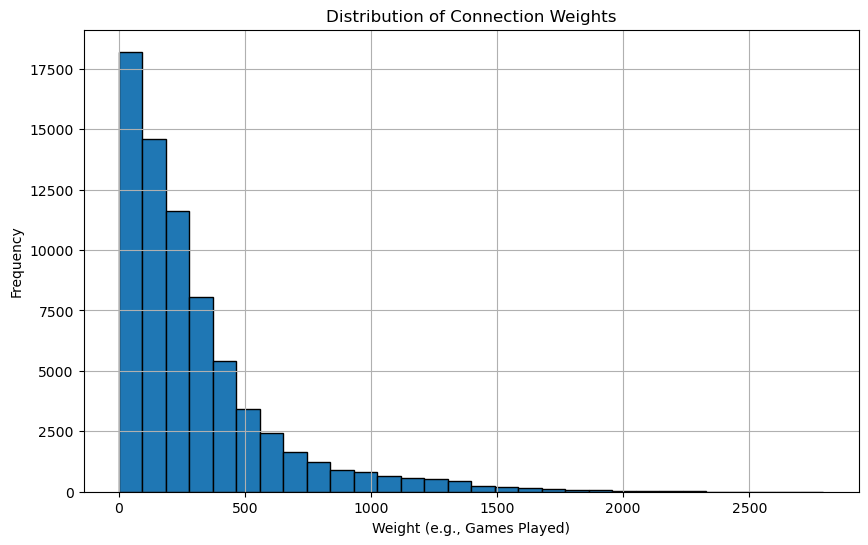

In [10]:
# CLet's first store the edges to a df
links = data['links']
df_links = pd.DataFrame(links)

# check basic stat
print("\nNumber of Edges:", len(df_links)) 
print("Average Connections per Player:", len(df_links) / len(df_nodes)) # Average degree 

# Connection weights
if 'weight' in df_links.columns:
    plt.figure(figsize=(10, 6))
    plt.hist(df_links['weight'], bins=30, edgecolor='k')
    plt.title("Distribution of Connection Weights")
    plt.xlabel("Weight (e.g., Games Played)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

# Rating differences
if 'rating_difference' in df_links.columns:
    plt.figure(figsize=(10, 6))
    plt.hist(df_links['rating_difference'], bins=30, edgecolor='k')
    plt.title("Distribution of Rating Differences")
    plt.xlabel("Rating Difference")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()


## Relationship of rating difference to win/loss ratio

Given the correlation matrix, we can see that there is 14% correlation between median rating difference with win/loss ratio. Players with higher median_rating_difference (indicating matched with weaker opponents) tend to have slightly higher win_loss_ratio.

In [11]:
# need to store the rating differences again but in list
player_rating_differences = defaultdict(list)

# same process as before
for _, _, attr in g.edges(data=True):
    for game in attr['data']:
        if game['white']['username'] in win_loss_df.index:
            player_rating_differences[game['white']['username']].append(game['white']['rating'] - game['black']['rating'])
        elif game['black']['username'] in win_loss_df.index:
            player_rating_differences[game['black']['username']].append(game['black']['rating'] - game['white']['rating'])

# Calculate median rating difference for each player
win_loss_df['median_rating_difference'] = win_loss_df.index.map(
    lambda player: np.median(player_rating_differences[player])
    if player in player_rating_differences and len(player_rating_differences[player]) > 0 else 0
)

# Calculate correlation between win/loss ratio and median rating difference
correlation = win_loss_df[['win_loss_ratio', 'median_rating_difference']].corr()
print("Correlation Matrix:")
print(correlation)

Correlation Matrix:
                          win_loss_ratio  median_rating_difference
win_loss_ratio                    1.0000                    0.1415
median_rating_difference          0.1415                    1.0000


Given the rating distribution being non-normal, a Spearman correlation would be more accurate. The value of 0.3399 indicates a moderate positive monotonic relationship between median_rating_difference and win_loss_ratio. This means that facing weaker opponents gives players a notable advantage in maintaining higher win/loss ratios, though the relationship is not overwhelmingly strong. When calculated correlation with total games played, the value was lower than rating difference. This indicates that although the more games player play, the higher win/loss ratio, rating difference between players play a higher role in winning. 

In [12]:

# extract only players without nan values
filtered_df = win_loss_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['win_loss_ratio', 'median_rating_difference', 'total_games'])


# perform Spearman correlation
spearman_corr, p_value = spearmanr(filtered_df['median_rating_difference'], filtered_df['win_loss_ratio'])
print(f"Spearman Correlation: {spearman_corr}")
print(f"P-value: {p_value}")

Spearman Correlation: 0.3389773951687442
P-value: 0.0


In [13]:
# spearman correlation with total games
corr_total_games, p_total_games = spearmanr(filtered_df['total_games'], filtered_df['win_loss_ratio'])
print(f"Spearman Correlation (Total Games vs Win/Loss Ratio): {corr_total_games}, P-value: {p_total_games}")


Spearman Correlation (Total Games vs Win/Loss Ratio): 0.11204918919806926, P-value: 1.3135915313850598e-55


The coefficients of the variables in the regression model were all significant. However, given the adjusted R-squared value of 3%, it indicates that variables such as median rating difference and total games only explains 3% of the variability in predicting win/loss ratio. 

In [14]:


# Define predictors (median_rating_difference and total_games) and response (win_loss_ratio)
X = filtered_df[['median_rating_difference', 'total_games']]
X = sm.add_constant(X)  # intercept
y = filtered_df['win_loss_ratio']

# Fit the regression model
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         win_loss_ratio   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     302.0
Date:                Thu, 21 Nov 2024   Prob (F-statistic):          6.85e-130
Time:                        22:46:45   Log-Likelihood:            -4.1597e+05
No. Observations:               19534   AIC:                         8.319e+05
Df Residuals:                   19531   BIC:                         8.320e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

## Summary

So far, we have determined that player rating distribution is non-normal and rather skewed to represent higher ratings. We have also determined that just by rating difference and number of games makes it difficult to extract anomalies. Therefore we decided to choose community detection method in order to extract anomalies. In this method, we use the fact that the network_with_fake data contains five fake anomalies named **findwaldo**. The following steps were used to extract anomalies. 

# Community Detection

## 1. Perform Initial Community Detection

We will use Louvain community detection to identify the communities and locate the one containing the fake players (findwaldo[1-5]).



In [15]:
random.seed(1121)
# Cited : https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html

# Add metrics to nodes
for node in g.nodes():
    node_data = g.nodes[node]
    node_data['win_loss_ratio'] = node_data.get('wins', 0) / max(node_data.get('losses', 1), 1)
    node_data['total_connections'] = g.degree(node)  # Total number of games played
    node_data['elo_rating'] = node_data.get('rating', 0)  # Elo rating
    node_data['rating_diff'] = abs(node_data.get('rating', 0) - node_data.get('opponent_rating', 0))  

# Add metrics to edges
for u, v, data in g.edges(data=True):
    game_data = data.get('data', [])
    for game in game_data:
        time_class = game.get('time_class')
        if time_class == 'bullet':
            game['time_class_binary'] = 1  # Bullet style
        elif time_class == 'blitz':
            game['time_class_binary'] = 2  # Blitz style
        elif time_class == 'rapid':
            game['time_class_binary'] = 3  # Rapid style
        elif time_class == 'daily':
            game['time_class_binary'] = 4  # Daily style
        else:
            game['time_class_binary'] = 0  # Unknown or missing time class

# Perform Louvain community detection
partition = community_louvain.best_partition(g)

# Assign community IDs to nodes
for node, community_id in partition.items():
    g.nodes[node]['community'] = community_id


In [16]:


# Identify fake Waldo players and their community
fake_players = [node for node in g.nodes if node.startswith("findwaldo")]
fake_communities = {g.nodes[player]['community'] for player in fake_players}

print("Fake Player Communities:", fake_communities)


Fake Player Communities: {0}


In [17]:
# Extract metrics for the fake Waldo players
fake_waldo_metrics = [
    {
        "username": g.nodes[node]["username"],
        "win_loss_ratio": g.nodes[node].get("win_loss_ratio", 0),
        "total_connections": g.nodes[node].get("total_connections", 0),
        "elo_rating": g.nodes[node].get("elo_rating", 0),
        "rating_diff": g.nodes[node].get("rating_diff", 0),
        "community": g.nodes[node].get("community")
    }
    for node in fake_players
]

# Convert to DataFrame for easier analysis
fake_waldo_df = pd.DataFrame(fake_waldo_metrics)

# Print metrics for the fake Waldo players
print("Fake Waldo Player Metrics:")
print(fake_waldo_df)

# Check summary statistics of fake Waldo players
print("\nSummary Statistics for Fake Waldo Players:")
print(fake_waldo_df.describe())


Fake Waldo Player Metrics:
     username  win_loss_ratio  total_connections  elo_rating  rating_diff  \
0  findwaldo1             0.0                 29        3000         3000   
1  findwaldo2             0.0                 15         400          400   
2  findwaldo3             0.0                 17        1750         1750   
3  findwaldo4             0.0                 12        2500         2500   
4  findwaldo5             0.0                 14         750          750   

   community  
0          0  
1          0  
2          0  
3          0  
4          0  

Summary Statistics for Fake Waldo Players:
       win_loss_ratio  total_connections   elo_rating  rating_diff  community
count             5.0           5.000000     5.000000     5.000000        5.0
mean              0.0          17.400000  1680.000000  1680.000000        0.0
std               0.0           6.730527  1109.391725  1109.391725        0.0
min               0.0          12.000000   400.000000   400.0000

We have completed the initial community detection and identified that the five fake Waldos belong to community 0. Below is the list of neighbors in the fake Waldo community along with their metric statistics. Interestingly, the players in the fake Waldo community exhibit a high rating difference but have a win/loss ratio of 0. This suggests that these players may not have won any games, which raises questions about their gameplay behavior and interaction with the fake Waldos.

In [18]:
# Extract nodes in the fake Waldo community
fake_community_id = next(iter(fake_communities))
fake_community_nodes = [node for node, data in g.nodes(data=True) if data['community'] == fake_community_id]
# Extract community metrics
community_features = []
for node in fake_community_nodes:
    data = g.nodes[node]
    community_features.append({
        "username": data.get("username", node),
        "win_loss_ratio": data.get("win_loss_ratio", 0),
        "elo_rating": data.get("elo_rating", 0),
        "rating_diff": data.get("rating_diff", 0),
        "total_connections": data.get("total_connections", 0),
        "time_class_binary": data.get("time_class_binary", 0)
    })

community_df = pd.DataFrame(community_features)
print("Fake Waldo Community Features:")
print(community_df.describe())
print("Players in Fake Waldo Community:")
print(community_df["username"].tolist())
print(len(community_df["username"].tolist()))

Fake Waldo Community Features:
       win_loss_ratio   elo_rating  rating_diff  total_connections  \
count           149.0   149.000000   149.000000         149.000000   
mean              0.0  2072.295302  2072.295302           8.845638   
std               0.0   336.012618   336.012618          17.402906   
min               0.0   400.000000   400.000000           1.000000   
25%               0.0  1967.000000  1967.000000           1.000000   
50%               0.0  2125.000000  2125.000000           2.000000   
75%               0.0  2269.000000  2269.000000          10.000000   
max               0.0  3000.000000  3000.000000         115.000000   

       time_class_binary  
count              149.0  
mean                 0.0  
std                  0.0  
min                  0.0  
25%                  0.0  
50%                  0.0  
75%                  0.0  
max                  0.0  
Players in Fake Waldo Community:
['ecztery', 'zera_kv', 'chesschief24', 'nebrabp', 'crazymaxxx'

In [19]:
# Compare rating differences
all_rating_differences = [g.nodes[node].get('rating_diff', 0) for node in g.nodes()]
fake_community_rating_differences = community_df['rating_diff'].tolist()

# Perform t-test
t_stat, p_value = ttest_ind(fake_community_rating_differences, all_rating_differences)

print(f"T-Test Results: t-stat = {t_stat}, p-value = {p_value}")


T-Test Results: t-stat = 7.0353138820680545, p-value = 2.052122361620802e-12


If we compare the rating difference for players within the fake waldo community compared to the other communitinities using a t-test, we can see that the rating difference is significantly different compared to other communities. 

## Refined Community Detection

In [20]:


# extract nodes to another df
feature_df = pd.DataFrame([
    {
        "username": g.nodes[node]["username"],
        "elo_rating": g.nodes[node].get("elo_rating", 0),
        "win_loss_ratio": g.nodes[node].get("win_loss_ratio", 0),
        "rating_diff": g.nodes[node].get("rating_diff", 0),
        "total_connections": g.nodes[node].get("total_connections", 0),
        "community": g.nodes[node].get("community"),
    }
    for node in g.nodes()
])

# let's scale them
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(feature_df[["elo_rating", "win_loss_ratio", "rating_diff", "total_connections"]])
feature_df[["elo_rating", "win_loss_ratio", "rating_diff", "total_connections"]] = scaled_features

# add composite metric (sum of scaled features)
feature_df["composite_metric"] = (
    feature_df["elo_rating"] + feature_df["win_loss_ratio"] + feature_df["rating_diff"] + feature_df["total_connections"]
)


In [21]:
# add composite metric back to graph nodes
for _, row in feature_df.iterrows():
    node = row["username"]
    g.nodes[node]["composite_metric"] = row["composite_metric"]

# adjust edge weights using the composite metric
for u, v, data in g.edges(data=True):
    data["weight"] = g.nodes[u].get("composite_metric", 0) + g.nodes[v].get("composite_metric", 0)

# perform community detection with updated weights
refined_partition = community_louvain.best_partition(g, weight="weight")

# assign refined community IDs to nodes
for node, community_id in refined_partition.items():
    g.nodes[node]["refined_community"] = community_id


In [22]:
# Identify refined communities containing fake waldos
refined_fake_communities = {g.nodes[player]["refined_community"] for player in fake_players}

# calculate precition and recall
detected_fake_players = [player for player in fake_players if g.nodes[player]["refined_community"] in refined_fake_communities]
precision = len(detected_fake_players) / len(fake_players)
recall = len(detected_fake_players) / len(fake_community_nodes)
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1_score}")

Precision: 1.0, Recall: 0.03355704697986577, F1-Score: 0.06493506493506493


In [23]:

# start with an empty dict
t_test_results = {}

# for each variable, perform a t-test to test significance.
variables_to_test = ["composite_metric", "win_loss_ratio", "elo_rating", "rating_diff", "total_connections"]

for var in variables_to_test:
    all_values = feature_df[var].tolist()
    fake_community_values = feature_df[feature_df["community"].isin(refined_fake_communities)][var].tolist()
    t_stat, p_value = ttest_ind(fake_community_values, all_values, nan_policy='omit')  # if NaN, omit.
    t_test_results[var] = {"t-stat": t_stat, "p-value": p_value}

print("T-Test Results:")
for var, results in t_test_results.items():
    print(f"{var} - t-stat = {results['t-stat']:.4f}, p-value = {results['p-value']:.4e}")


T-Test Results:
composite_metric - t-stat = -10.5401, p-value = 6.5391e-26
win_loss_ratio - t-stat = nan, p-value = nan
elo_rating - t-stat = -10.4382, p-value = 1.9123e-25
rating_diff - t-stat = -10.4382, p-value = 1.9123e-25
total_connections - t-stat = -2.9620, p-value = 3.0595e-03


In [24]:
# confusion matrix
feature_df["is_fake"] = feature_df["username"].isin(fake_players).astype(int)
feature_df["predicted_fake"] = feature_df["community"].isin(refined_fake_communities).astype(int)

conf_matrix = confusion_matrix(feature_df["is_fake"], feature_df["predicted_fake"])
print("Confusion Matrix:\n", conf_matrix)
print(classification_report(feature_df["is_fake"], feature_df["predicted_fake"]))

Confusion Matrix:
 [[18581  1341]
 [    5     0]]
              precision    recall  f1-score   support

           0       1.00      0.93      0.97     19922
           1       0.00      0.00      0.00         5

    accuracy                           0.93     19927
   macro avg       0.50      0.47      0.48     19927
weighted avg       1.00      0.93      0.96     19927



## Another - Adding more Fake Waldos

In [25]:

# Create duplicates for oversampling
num_duplicates = 10  
for node in fake_players:
    for i in range(num_duplicates):
        new_node_id = f"{node}_dup{i+1}"
        g.add_node(new_node_id, **copy.deepcopy(g.nodes[node])) # we want duplicates to have similar attributes
        
        # connect duplicates to the same edges as the original node
        for neighbor in g.neighbors(node):
            edge_data = g.get_edge_data(node, neighbor)
            g.add_edge(new_node_id, neighbor, **copy.deepcopy(edge_data))

print(f"Added {len(fake_players) * num_duplicates} duplicate nodes for oversampling.")

Added 50 duplicate nodes for oversampling.


In [26]:
# performing community detection after oversampling
oversampled_partition = community_louvain.best_partition(g)

# assign community labels to nodes
for node, community_id in oversampled_partition.items():
    g.nodes[node]['community_oversampled'] = community_id

# Identify the communities containing fake players
oversampled_fake_communities = {g.nodes[player]['community_oversampled'] for player in fake_players}

print("Communities containing fake players (after oversampling):", oversampled_fake_communities)


Communities containing fake players (after oversampling): {3}


In [27]:
# let's extract nodes from fake community
oversampled_fake_community_id = next(iter(oversampled_fake_communities))
oversampled_fake_community_nodes = [
    node for node, data in g.nodes(data=True) 
    if data.get('community_oversampled') == oversampled_fake_community_id
]

# get features for the community
oversampled_community_features = []
for node in oversampled_fake_community_nodes:
    data = g.nodes[node]
    oversampled_community_features.append({
        "username": data.get("username", node),
        "win_loss_ratio": data.get("win_loss_ratio", 0),
        "elo_rating": data.get("elo_rating", 0),
        "rating_diff": data.get("rating_diff", 0),
        "total_connections": data.get("total_connections", 0),
        "time_class_binary":data.get("time_class_binary",0)
    })

oversampled_community_df = pd.DataFrame(oversampled_community_features)
print("\nOversampled Fake Waldo Community Features:")
print(oversampled_community_df.describe())



Oversampled Fake Waldo Community Features:
       win_loss_ratio   elo_rating  rating_diff  total_connections  \
count           238.0   238.000000   238.000000         238.000000   
mean              0.0  1864.054622  1864.054622           9.542017   
std               0.0   594.785123   594.785123          19.503876   
min               0.0   400.000000   400.000000           1.000000   
25%               0.0  1609.000000  1609.000000           1.000000   
50%               0.0  2012.000000  2012.000000           2.000000   
75%               0.0  2227.750000  2227.750000          14.000000   
max               0.0  3000.000000  3000.000000         184.000000   

       time_class_binary  
count              238.0  
mean                 0.0  
std                  0.0  
min                  0.0  
25%                  0.0  
50%                  0.0  
75%                  0.0  
max                  0.0  


In [28]:
# adjust edge weights using updated composite metrics
for u, v, data in g.edges(data=True):
    data['weight'] = (
        g.nodes[u].get('composite_metric', 0) + g.nodes[v].get('composite_metric', 0)
    )

# run a community detection again
refined_partition_after_oversampling = community_louvain.best_partition(g, weight="weight")

# Assign labels to nodes
for node, community_id in refined_partition_after_oversampling.items():
    g.nodes[node]['refined_community_oversampled'] = community_id


In [29]:
# identify refined communities containing fake players
refined_fake_communities_after_oversampling = {
    g.nodes[player]['refined_community_oversampled'] for player in fake_players
}

# calculate precision, recall, f1score 
detected_fake_players_oversampled = [
    player for player in fake_players 
    if g.nodes[player]['refined_community_oversampled'] in refined_fake_communities_after_oversampling
]

precision = len(detected_fake_players_oversampled) / len(fake_players)
recall = len(detected_fake_players_oversampled) / len(oversampled_fake_community_nodes)
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("\nClassification Metrics After Oversampling:")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1_score}")



Classification Metrics After Oversampling:
Precision: 1.0
Recall: 0.02100840336134454
F1-Score: 0.041152263374485604


In [30]:
# compare rating differences with the rest of the graph
oversampled_all_rating_differences = [
    g.nodes[node].get('rating_diff', 0) for node in g.nodes()
]
oversampled_fake_rating_differences = oversampled_community_df['rating_diff'].tolist()

from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(oversampled_fake_rating_differences, oversampled_all_rating_differences)

print(f"\nT-Test Results After Oversampling: t-stat = {t_stat}, p-value = {p_value}")



T-Test Results After Oversampling: t-stat = 3.13356059903229, p-value = 0.0017294611082938748


In [31]:

community_vs_graph_results = {}

# perform t-tests for each variable
for variable in ["win_loss_ratio", "elo_rating", "rating_diff", "total_connections"]:
    # get variable values for fake community
    oversampled_fake_values = oversampled_community_df[variable].tolist()
    
    # get variable values for the rest of the graph
    all_graph_values = [g.nodes[node].get(variable, 0) for node in g.nodes()]
    
    # perform t-test
    t_stat, p_value = ttest_ind(oversampled_fake_values, all_graph_values, equal_var=False)
    community_vs_graph_results[variable] = {"t_stat": t_stat, "p_value": p_value}


print("\nT-Test Results After Oversampling:")
for variable, stats in community_vs_graph_results.items():
    print(f"{variable.capitalize()} - t-stat = {stats['t_stat']:.4f}, p-value = {stats['p_value']:.4e}")



T-Test Results After Oversampling:
Win_loss_ratio - t-stat = nan, p-value = nan
Elo_rating - t-stat = 2.9579, p-value = 3.4043e-03
Rating_diff - t-stat = 2.9579, p-value = 3.4043e-03
Total_connections - t-stat = 1.8183, p-value = 7.0190e-02


In [44]:
# Add metrics to nodes based on the result
for node in g.nodes:
    g.nodes[node]["weighted_degree"] = g.degree(node, weight="weight")  # Sum of connection weights
    g.nodes[node]["total_connections"] = g.degree(node)  # Number of edges (unweighted)
    g.nodes[node]["win_loss_ratio"] = g.nodes[node].get("win_loss_ratio", 0)  # Win/Loss Ratio
    g.nodes[node]["elo_rating"] = g.nodes[node].get("elo_rating", 0)  # Elo Rating
    g.nodes[node]["rating_diff"] = g.nodes[node].get("rating_diff", 0)  # Rating Difference

# Extract relevant metrics into a df
metrics = []
for node, data in g.nodes(data=True):
    metrics.append({
        "username": data.get("username", node),
        "weighted_degree": data.get("weighted_degree", 0),
        "total_connections": data.get("total_connections", 0),
        "win_loss_ratio": data.get("win_loss_ratio", 0),
        "elo_rating": data.get("elo_rating", 0),
        "rating_diff": data.get("rating_diff", 0),
        "community": data["community"]
    })

metrics_df = pd.DataFrame(metrics)

In [ ]:
# identify fake Waldo community again
fake_community_nodes = metrics_df[metrics_df["community"].isin(refined_fake_communities)]
rest_of_graph = metrics_df[~metrics_df["community"].isin(refined_fake_communities)]

# Perform t-tests for significance across all metrics

results = {}
for metric in ["weighted_degree", "total_connections", "win_loss_ratio", "elo_rating", "rating_diff"]:
    t_stat, p_value = ttest_ind(
        fake_community_nodes[metric],
        rest_of_graph[metric],
        equal_var=False 
    )
    results[metric] = {"t_stat": t_stat, "p_value": p_value}


In [45]:
# Flag nodes with significant deviations based on weighted_degree 
fake_community_nodes["anomaly_score"] = (
    0.5 * (fake_community_nodes["rating_diff"] - fake_community_nodes["rating_diff"].mean()) / fake_community_nodes["rating_diff"].std()
    + 0.5 * (fake_community_nodes["elo_rating"] - fake_community_nodes["elo_rating"].mean()) / fake_community_nodes["elo_rating"].std()
)
anomalous_nodes = fake_community_nodes[fake_community_nodes["anomaly_score"] > 2]  # assign anomaly score (Z-score > 2 as anomaly threshold)

# Exclude fake Waldo nodes
anomalous_nodes = anomalous_nodes[~anomalous_nodes["username"].str.startswith("findwaldo")]

print("T-Test Results:")
for metric, values in results.items():
    print(f"{metric}: t-stat = {values['t_stat']:.4f}, p-value = {values['p_value']:.4e}")

print("\nAnomalous Nodes in Fake Waldo Community (Excluding Fake Waldos):")
print(anomalous_nodes[[
    "username", "weighted_degree", "total_connections", "anomaly_score", 
    "rating_diff", "elo_rating", "win_loss_ratio"
]])

T-Test Results:
weighted_degree: t-stat = -5.5713, p-value = 2.8833e-08
total_connections: t-stat = -4.3442, p-value = 1.4765e-05
win_loss_ratio: t-stat = nan, p-value = nan
elo_rating: t-stat = -11.5706, p-value = 9.1895e-30
rating_diff: t-stat = -11.5706, p-value = 9.1895e-30

Anomalous Nodes in Fake Waldo Community (Excluding Fake Waldos):
         username  weighted_degree  total_connections  anomaly_score  \
10610  tomoe_nage         7.164223                  2        2.12102   

       rating_diff  elo_rating  win_loss_ratio  
10610         2722        2722             0.0  


C:\Users\yeban\AppData\Local\Temp\ipykernel_9964\3022167416.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_community_nodes["anomaly_score"] = (


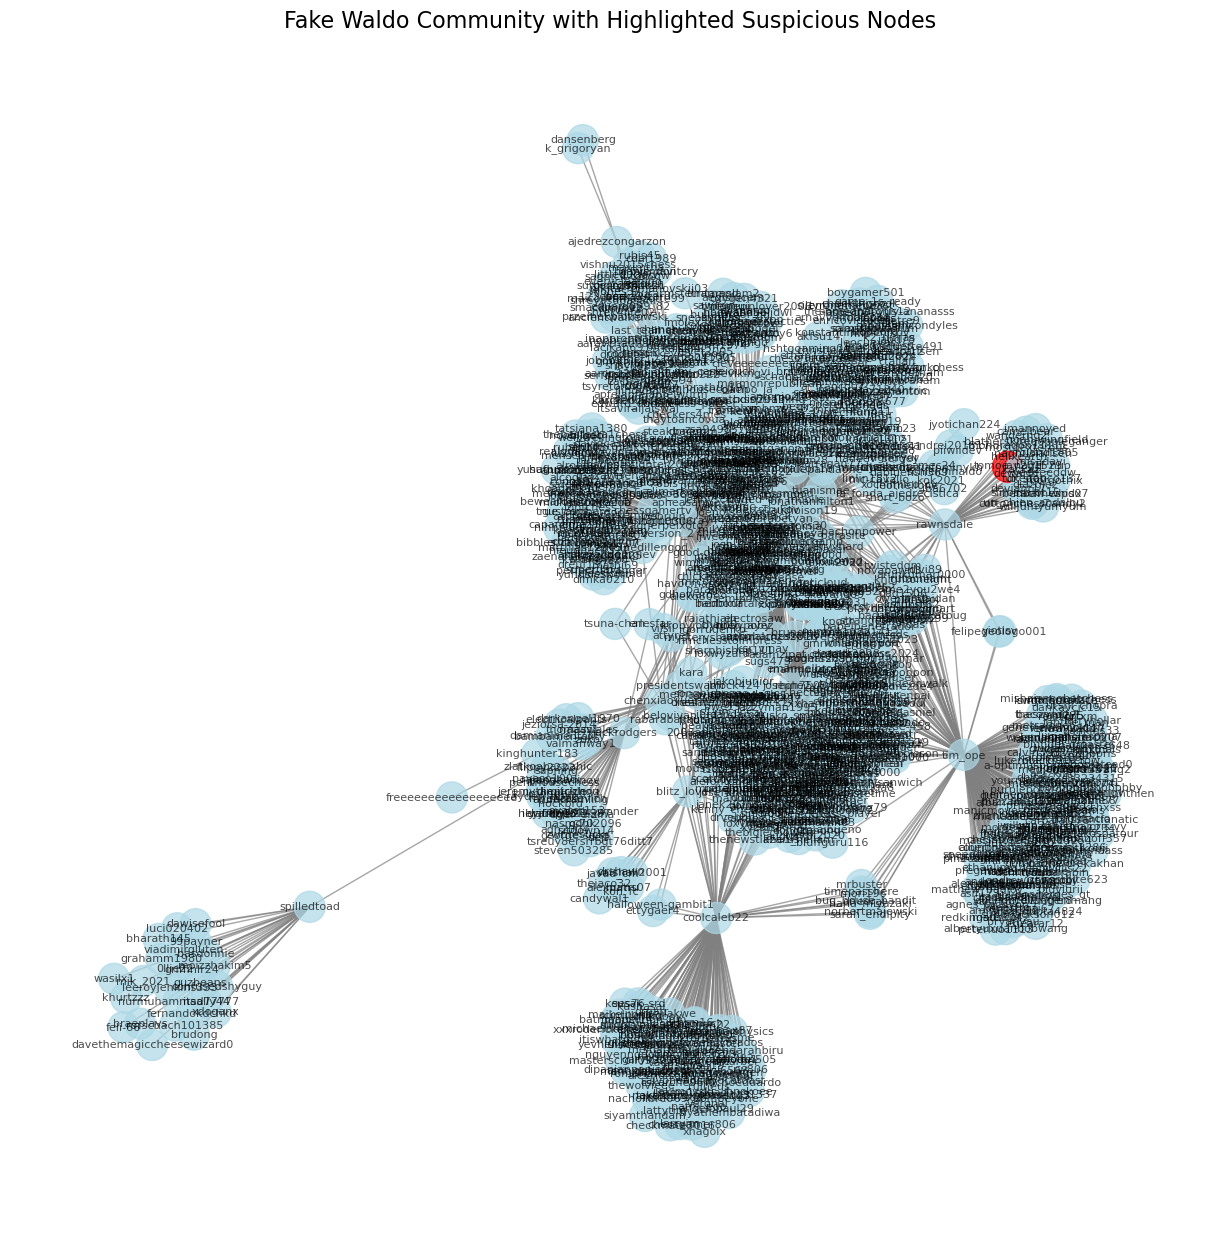

In [42]:
# Create the subgraph for the Fake Waldo community
fake_waldo_subgraph = g.subgraph(fake_community_nodes["username"].tolist())

# Define node colors based on whether the node is suspicious
node_colors = []
for node in fake_waldo_subgraph.nodes():
    if node in anomalous_nodes["username"].tolist():
        node_colors.append("red")  # suspicious nodes in red
    else:
        node_colors.append("lightblue")  # normal nodes in light blue

# Draw the subgraph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(fake_waldo_subgraph, seed=42)  
nx.draw(
    fake_waldo_subgraph,
    pos,
    with_labels=True,
    node_color=node_colors,
    node_size=500,
    font_size=8,
    font_color="black",
    edge_color="gray",
    alpha=0.7
)
plt.title("Fake Waldo Community with Highlighted Suspicious Nodes", fontsize=16)
plt.show()